****IMAGE CLASSIFICATION USING CONVOLUTIONAL NEURAL NETWORKS****

in this we will use the CIFAR10 dataset which consists of 60k 32x32 px colour images in 10 classes 

In [1]:
import os
import torch
import torchvision
import tarfile
from torchvision.datasets.utils import download_url
from torch.utils.data import random_split

In [2]:
dataset_url = "https://s3.amazonaws.com/fast-ai-imageclas/cifar10.tgz"
download_url(dataset_url,'.')

100%|██████████| 135M/135M [00:03<00:00, 44.8MB/s] 


In [3]:
#extract from archieve
with tarfile.open('./cifar10.tgz','r:gz') as tar:
    tar.extractall(path = './data')

/tmp/ipython-input-2596448101.py:3: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall(path = './data')


In [4]:
data_dir = './data/cifar10'
print(os.listdir(data_dir))
classes = os.listdir(data_dir + '/train')
print(classes)

['train', 'test']
['truck', 'deer', 'bird', 'frog', 'dog', 'automobile', 'ship', 'cat', 'horse', 'airplane']


we can use the imagefolder class from torchvision to load the data as pytorch tensors

In [5]:
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor

In [6]:
dataset = ImageFolder(data_dir+'/train',transform = ToTensor())

each image is a tensor of shape 3 32 32

In [7]:
img , label = dataset[342]
print(img.shape,label)
img

torch.Size([3, 32, 32]) 0


tensor([[[0.9490, 0.9569, 0.9647,  ..., 0.8667, 0.8627, 0.8471],
         [0.9686, 0.9804, 0.9804,  ..., 0.8824, 0.8667, 0.8392],
         [0.9725, 0.9725, 0.9725,  ..., 0.8745, 0.8510, 0.8157],
         ...,
         [0.8353, 0.8471, 0.8471,  ..., 0.7608, 0.7608, 0.7490],
         [0.8196, 0.8275, 0.8275,  ..., 0.7373, 0.7373, 0.7294],
         [0.8118, 0.8078, 0.8078,  ..., 0.7255, 0.7216, 0.7176]],

        [[0.9490, 0.9569, 0.9647,  ..., 0.8667, 0.8627, 0.8471],
         [0.9686, 0.9804, 0.9804,  ..., 0.8824, 0.8667, 0.8392],
         [0.9725, 0.9725, 0.9725,  ..., 0.8745, 0.8510, 0.8157],
         ...,
         [0.8353, 0.8471, 0.8471,  ..., 0.7608, 0.7608, 0.7490],
         [0.8196, 0.8275, 0.8275,  ..., 0.7373, 0.7373, 0.7294],
         [0.8118, 0.8078, 0.8078,  ..., 0.7255, 0.7216, 0.7176]],

        [[0.9490, 0.9569, 0.9647,  ..., 0.8667, 0.8627, 0.8471],
         [0.9686, 0.9804, 0.9804,  ..., 0.8824, 0.8667, 0.8392],
         [0.9725, 0.9725, 0.9725,  ..., 0.8745, 0.8510, 0.

the list of classes is stored in the .classes property of the dataset the numberic label for each element corresponds to index of the elements label in the list of classes 

In [8]:
print(dataset.classes)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [9]:
import matplotlib
import matplotlib.pyplot as plt



In [10]:
def show_example(img,label):
    print('label',dataset.classes[label],"(" +str(label)+")")
    plt.imshow(img.permute(1,2,0))

label airplane (0)


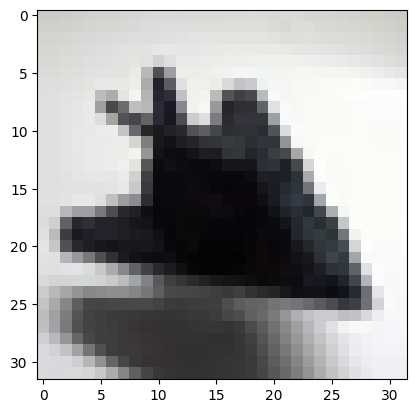

In [11]:
show_example(*dataset[0])

label airplane (0)


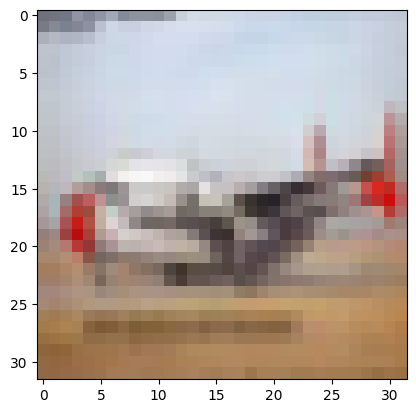

In [12]:
show_example(*dataset[1099])

****Training and validation Datasets****

1) training set 
2) validatoin set - used to evaluate the model while training , adjust hyperparameters (learning rate etc) and pick the best verison of the model
3) test set - used to compare different models or different types of modeling approaches and report the final accuracy of teh model 

since theres no predefined validation set , we can set aside a small portion 5k images of training set as validation set , we wil luse the random_split to do this

In [13]:
random_seed = 42
torch.manual_seed(random_seed)


In [14]:
val_size = 5000
train_size = len(dataset) - val_size
train_ds ,val_ds = random_split(dataset,[train_size,val_size])
len(train_ds),len(val_ds)

(45000, 5000)

we can now create dataloaders for training and validation to load teh data in batches

In [15]:
from torch.utils.data.dataloader import DataLoader
batch_size = 128

In [16]:
train_dl = DataLoader(train_ds,batch_size,shuffle=True,num_workers = 4,pin_memory=True)
val_dl = DataLoader(val_ds,batch_size*2,num_workers = 4,pin_memory=True)

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


### 🧩 Train, Validation, and Test Sets

- **Training set** → Used to train the model and update weights through backpropagation.  
- **Validation set** → Used during training to tune hyperparameters and select the best model (checks for overfitting).  
- **Test set** → Used only once after training to evaluate final model performance on unseen data.  

> In short: **Train = Learn**, **Validate = Tune**, **Test = Judge**


we can look at batches of images from the dataset using  the make_grid method from torch_vision . Each time the following code is run , we get a different batch, since the sampler shuffles the indices before createing batches

*********DEFINING THE MODEL(CONVOLUTIONAL NEURAL NETWORK)*********

previously we defined a deep neural network with fully connected layers using nn.Linear . In this we will use a convolutional  neural network , using the nn.Conv2d class from pytorch

the 2d cnn is a failry simple operation , we start with a kernel which is simply a small matrix of weights . This kernel "slides" over the 2d input data, performing an elementwise multiplication with the part of the input it is currently on , then summing up the results into a single output pixel

lets us implement a convolution operation on a 1 channel image with 3x3 kernel

In [22]:
def apply_kernel(image,kernel):
    ri,ci = image.shape #image dimensions
    rk,ck = kernel.shape #kernel dimensions
    ro,co = ri - rk + 1,ci - ck + 1 #output dimensions
    output = torch.zeros([ro,co])
    for i in range(ro):
        for j in range(co):
            output[i,j] = torch.sum(image[i:i+rk,j:j+ck]*kernel)
    return output        


In [23]:
sample_image = torch.tensor([
    [3,3,2,1,0],
    [0,0,1,3,1],
    [3,1,2,2,3],
    [2,0,0,2,2],
    [2,0,0,0,1]
],dtype = torch.float32)

sample_kernel = torch.tensor([
    [0,1,2],
    [2,2,0],
    [0,1,2]
],dtype = torch.float32)

apply_kernel(sample_image,sample_kernel)

tensor([[12., 12., 17.],
        [10., 17., 19.],
        [ 9.,  6., 14.]])

## 🧩 Padding in CNN

When a **Convolutional Neural Network (CNN)** applies a kernel (filter) over an image, it slides the filter across the input.  
However, each convolution operation **reduces the spatial dimensions (height & width)** of the image because the kernel cannot extend beyond the edges.

To prevent this and preserve information near the borders, we use **Padding**.

---

### 🔹 What is Padding?

**Padding** means adding extra pixels (usually zeros) around the border of the input image before performing convolution.  

This helps the filter (kernel) process the edge pixels just like the central ones.

---

### 🧠 Why Padding?

- Prevents reduction in output size after convolution  
- Preserves information at image borders  
- Allows deeper networks by keeping spatial dimensions consistent

---



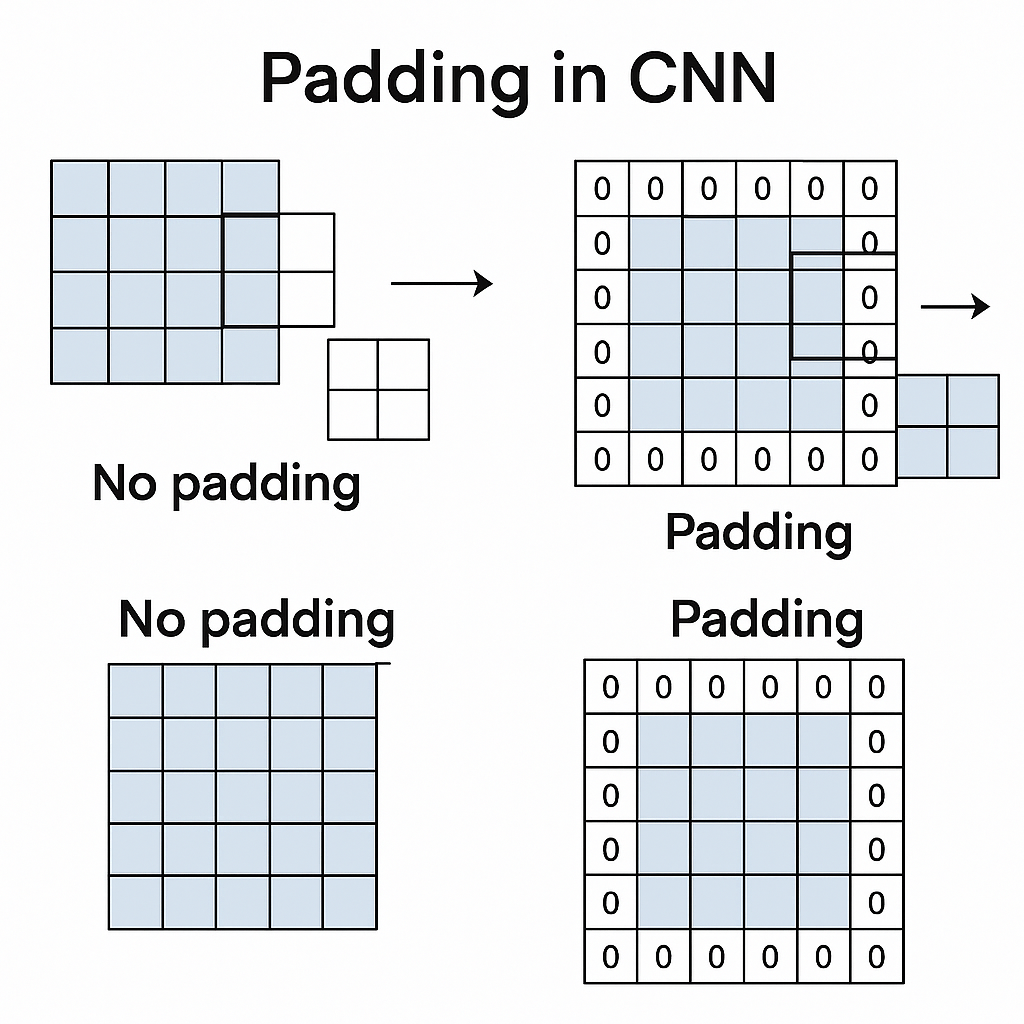

striding - while running a convolution layer if we wan tan output with a lower size than the input we jump 2 or 3 or more spaces instead of one while sliding the kernel this is called strid 2 stride 3 etc

max pooling

In [24]:
import torch.nn as nn
import torch.nn.functional as F